In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import FreqDist
from nltk.tokenize import word_tokenize

# Import Data

In [13]:
final_df = pd.read_csv('csv_files_test/cleaned_items_reviews_df.csv',index_col=0)
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...


In [14]:
# drop rows where cleaned_reviews are na
final_df.isna()
final_df = final_df.dropna(subset=['cleaned_reviews'])

# Class Imbalance

In [74]:
final_df['user_rating'].value_counts()

5.0    3495
4.0     704
1.0     566
3.0     444
2.0     278
Name: user_rating, dtype: int64

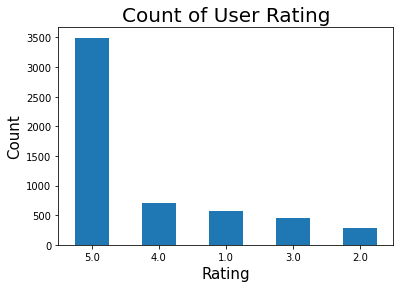

In [75]:
# plt.figure(figsize=(20,10))
final_df['user_rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10);

It appears we have a class imbalance problem where the number of 5.0 reviews are much greater than the other reviews. Oversampling the minority classes will lead to overfitting due to a creation of large number of synthetic rows. To address this, I will take a set number of random samples from each class.

## Undersampling

In [87]:
def undersampling(dataframe, column, list_user_rating, samples):
    df = pd.DataFrame()
    for rating in list_user_rating:
        sample = dataframe[dataframe[column] == rating].sample(samples)
        df = df.append(sample)
    return df

In [94]:
undersampled_df =undersampling(final_df, 'user_rating', final_df['user_rating'].unique(), 250)
undersampled_df.shape

(1250, 11)

# TF-IDF Vectorization

Stands for Term Frequency, Inverse Document Frequency and weighs each word in a document by how unique it is. The idea behind TF-IDF is that the words that occur less in all the documents and more in individual documents are weighted more.

In [15]:
# declare variables for reviews and rating
reviews = undersampled_df['cleaned_reviews'].values
rating = undersampled_df['user_rating'].values

In [16]:
# convert text into TF-IDF feature vectors

vectorizer = TfidfVectorizer(max_features=2500, # num of most frequent occuring words to create bag of words vector
                             min_df=7, # minimum words that occur in at least 7 documents
                             max_df=0.8, # words that occur in a maximum of 80% of documents
                             stop_words=stopwords.words('english'))

processed_features = vectorizer.fit_transform(reviews).toarray()

In [17]:
print(vectorizer)
print(processed_features)

TfidfVectorizer(max_df=0.8, max_features=2500, min_df=7,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
[[0.         0.         0.10829667 ... 0.         0.17790893 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(processed_features,
                                                    rating, 
                                                    test_size=0.2, # 80% training/20% test
                                                    random_state=0)

# Random Forest

## GridSearchCV

In [43]:
# Perform a gridsearch with Random Forest
# Obtain optimal values of model hyperparameters

RF_classifier = RandomForestClassifier(random_state=0)

params = {'criterion': ['gini','entropy'], # Measure the quality of a split
             'max_depth': [10, 20, 30], # Maximum number of levels in tree
             'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
             'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
             'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
             'n_estimators': [200, 500, 1000]} # The number of trees in the forest

g_s_RF = GridSearchCV(RF_classifier,param_grid=params, n_jobs=-1) # create gridsearch with input params
grid_result = g_s_RF.fit(X_train, y_train) # fit gridsearch with training data
best_params = grid_result.best_params_ # output best params for given data
best_params

In [ ]:
RF_classifier = RandomForestClassifier(#insert best params here ,random_state=0)

In [10]:
RF_predictions = RF_classifier.predict(X_test)
RF_predictions

NameError: name 'RF_classifier' is not defined

In [11]:
RF_predictions

NameError: name 'RF_predictions' is not defined

## Results

### Confusion Matrix

In [317]:
print(confusion_matrix(y_test, RF_predictions))

[[ 32   1   0   0  72]
 [ 10   0   0   0  46]
 [  5   0   0   2  84]
 [  2   0   0   1 115]
 [  4   0   0   2 722]]


### Classification Report

In [318]:
print(classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

         1.0       0.60      0.30      0.41       105
         2.0       0.00      0.00      0.00        56
         3.0       0.00      0.00      0.00        91
         4.0       0.20      0.01      0.02       118
         5.0       0.69      0.99      0.82       728

    accuracy                           0.69      1098
   macro avg       0.30      0.26      0.25      1098
weighted avg       0.54      0.69      0.58      1098



### Accuracy Score

In [319]:
print(accuracy_score(y_test, RF_predictions))

0.6876138433515483


In [345]:
accuracy_results = pd.DataFrame({'Model':['Random Forest'], 'Accuracy':[accuracy_score(y_test, predictions)]})
accuracy_results

,Model,Accuracy
0,Random Forest,0.687614


### Plot Comparison between Actuals and Predicted

In [321]:
predictions_count = dict(Counter(RF_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

random_forest_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

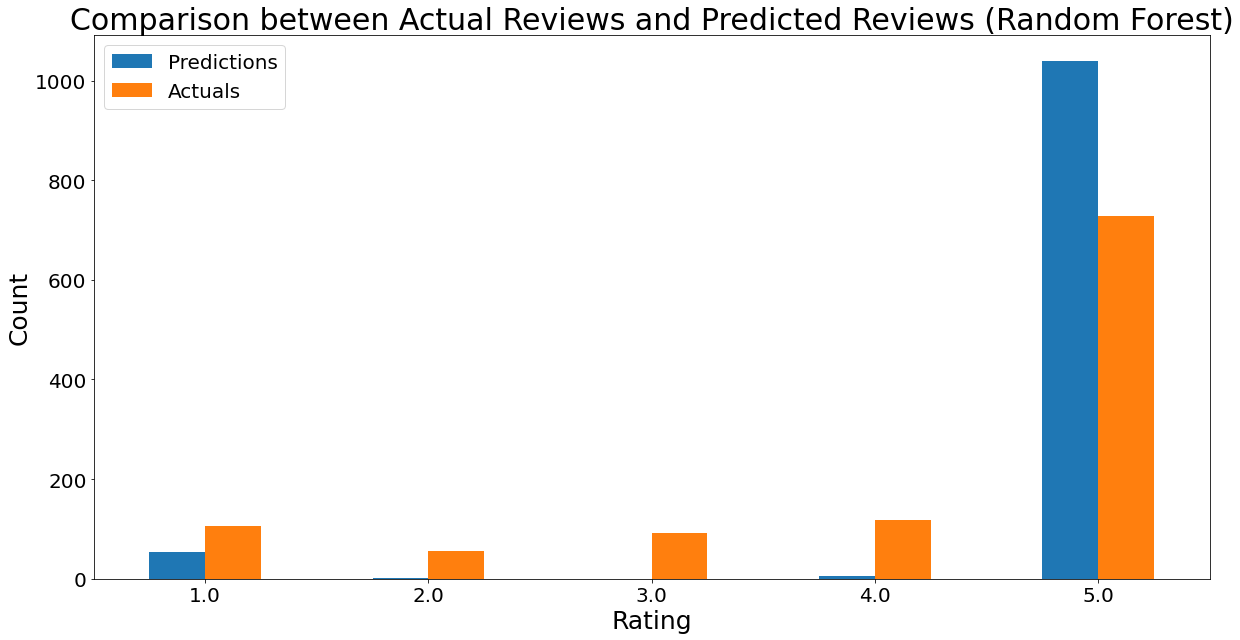

In [322]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (Random Forest)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# K-Nearest Neighbors (KNN)

In [323]:
KNN_classifier = KNeighborsClassifier(n_neighbors=5)
KNN_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [324]:
KNN_predictions = KNN_classifier.predict(X_test)
KNN_predictions

array([5., 5., 5., ..., 5., 5., 5.])

## Results

### Confusion Matrix

In [325]:
print(confusion_matrix(y_test, KNN_predictions))

[[  0   0   0   0 105]
 [  0   0   0   0  56]
 [  0   0   0   0  91]
 [  1   0   0   0 117]
 [  0   0   0   0 728]]


### Classification Report

In [326]:
print(classification_report(y_test, KNN_predictions))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       105
         2.0       0.00      0.00      0.00        56
         3.0       0.00      0.00      0.00        91
         4.0       0.00      0.00      0.00       118
         5.0       0.66      1.00      0.80       728

    accuracy                           0.66      1098
   macro avg       0.13      0.20      0.16      1098
weighted avg       0.44      0.66      0.53      1098



### Accuracy Score

In [327]:
print(accuracy_score(y_test, KNN_predictions))

0.663023679417122


In [346]:
accuracy_results = accuracy_results.append({'Model':'KNN', 'Accuracy':accuracy_score(y_test, KNN_predictions)},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Random Forest,0.687614
1,KNN,0.663024


### Plot Comparison between Actuals and Predicted

In [329]:
predictions_count = dict(Counter(KNN_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

KNN_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

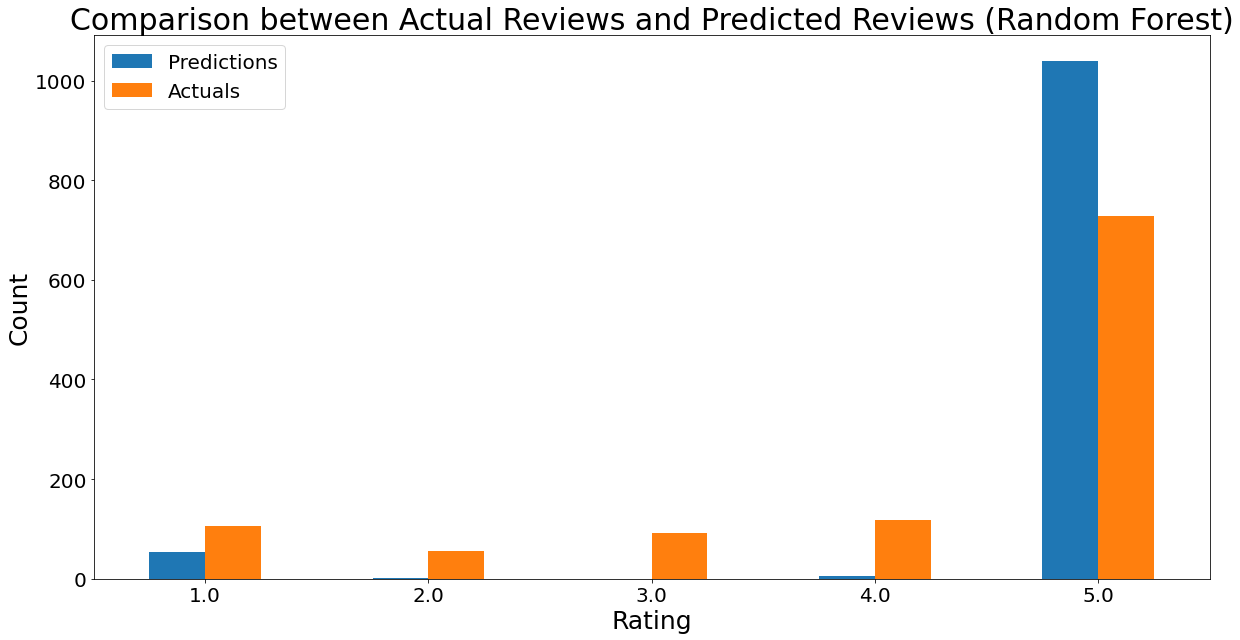

In [330]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (KNN)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# Sentiment Analyzer using NLTK Module Vader

* works well with social media type text
* doesn't require any training data and is constructed using human-curated sentiment lexicon

In [331]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [332]:
def sentiment_analyzer_scores(sentence):
    # polarity_scores: ranging from -1 (most neg) to 1 (most pos)
    score = analyser.polarity_scores(sentence)
    return score # {neg: Negative, neu: Neutral, pos: Positive, compound: Aggregated Score}

In [333]:
def compound_score(text):
    comp=sentiment_analyzer_scores(text)
    return comp['compound'] # returns the compound score from the dictionary

In [334]:
# applying on the reviews column to get the score
final_df['sentiment_score'] = final_df['review_description'].apply(lambda x:compound_score(x))

In [335]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,sentiment_score
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...,0.8548
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...,-0.4873
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...,0.2885
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...,0.8726
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...,0.9565


In [336]:
def sentiment_category(score):
    if score >= 0.6:
        return 5.0
    elif score >= 0.2:
        return 4.0
    elif score >= -0.2:
        return 3.0
    elif score >= -0.6:
        return 2.0
    else:
        return 1.0

In [337]:
final_df['sentiment_score_rating'] = final_df['sentiment_score'].apply(lambda x: sentiment_category(x))

In [338]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,sentiment_score,sentiment_score_rating
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...,0.8548,5.0
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...,-0.4873,2.0
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...,0.2885,4.0
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...,0.8726,5.0
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...,0.9565,5.0


## Results

### Confusion Matrix

In [339]:
cnf_matrix = confusion_matrix(final_df['user_rating'],final_df['sentiment_score_rating'])
cnf_matrix

array([[ 122,  105,   87,  103,  149],
       [  43,   42,   33,   39,  121],
       [  33,   39,   42,   72,  258],
       [  23,   24,   23,   69,  565],
       [  30,   52,   80,  209, 3124]])

### Classification Report

In [340]:
print(classification_report(final_df['user_rating'],final_df['sentiment_score_rating']))

              precision    recall  f1-score   support

         1.0       0.49      0.22      0.30       566
         2.0       0.16      0.15      0.16       278
         3.0       0.16      0.09      0.12       444
         4.0       0.14      0.10      0.12       704
         5.0       0.74      0.89      0.81      3495

    accuracy                           0.62      5487
   macro avg       0.34      0.29      0.30      5487
weighted avg       0.56      0.62      0.58      5487



### Accuracy Score

In [341]:
from sklearn.metrics import accuracy_score
vader_accuracy_score = accuracy_score(final_df['user_rating'],final_df['sentiment_score_rating'])
vader_accuracy_score

0.6194641880809185

In [347]:
accuracy_results = accuracy_results.append({'Model':'Vader', 'Accuracy':vader_accuracy_score},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Random Forest,0.687614
1,KNN,0.663024
2,Vader,0.619464


### Plot Comparison between Actuals and Predicted

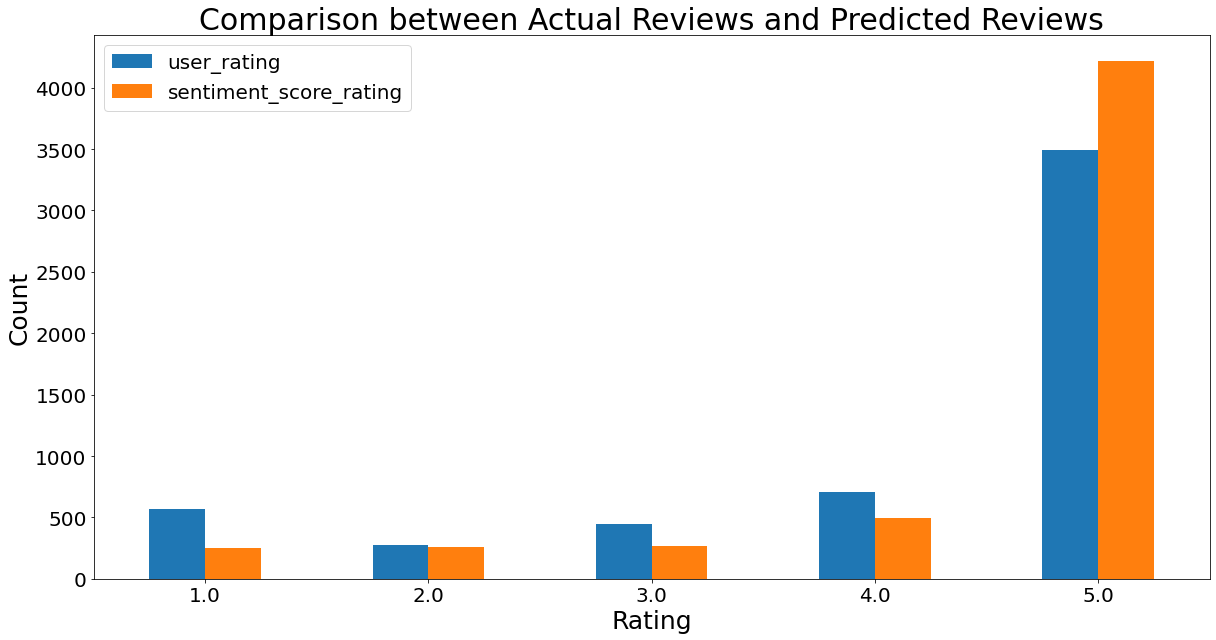

In [343]:
review_rating_counts = final_df['user_rating'].value_counts()
sentiment_score_rating_counts = final_df['sentiment_score_rating'].value_counts()

review_df = pd.concat([review_rating_counts, sentiment_score_rating_counts], axis=1)

review_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# Predictive Accuracy Results

In [348]:
accuracy_results

,Model,Accuracy
0,Random Forest,0.687614
1,KNN,0.663024
2,Vader,0.619464
